# Run 1.4 5.10.23
- update this
- 9 days (464 x 9 x 8600= 35.9M total FFTs, 2^24, 800MHz clock) 
- switch antenna and term (switch=1 is terminator. 1/16 duty cycle) 
- 4dB fixed attenuation, pasternack 1012E to mini circuits zkl1r5+A (9V regulated from battery). 
- Run started 5-10-23 at 11:32:48. 
- Right at clipping

In [1]:
import sys 
import numpy as np
import settings as s
import matplotlib.pyplot as plt 
import importlib
importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime
import pandas as pd
import math
from scipy.optimize import curve_fit

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

dataDir         = '/drBiggerBoy/run1p4/'
filename        = 'packedh5.hdf5'
databaseFile    = 'database.txt'

antSpecSufix    = 'ALL_33p6M_FFTs_11_16_23'
termSpecSufix   = 'ALL_2p2M_FFTs_11_16_23'
vetoSpecSufix   = 'ALL_33p6M_FFTs_11_16_23'

databaseDf      = pd.read_csv(dataDir + databaseFile)

totalAcqs       = int(open(dataDir + databaseFile, 'r'
                    ).readlines()[-1].split(',')[0].strip()) + 1 

print(totalAcqs)
    
# Generate antIdx and termIdx from database file
# Open the data file and read the lines
# should rewrite this to use DF
with open(dataDir + databaseFile, 'r') as f:
    # Skip the header line
    next(f)
    # Initialize the two arrays
    antIdx = []
    termIdx = []
    # Loop through the remaining lines and extract the acqNum values
    for line in f:
        # Split the line into fields
        fields = line.strip().split(',')
        # Extract the SWITCH_POS and ACQ NUM values
        switch_pos = int(fields[2])
        acq_num = int(fields[0])
        # Append the acqNum value to the appropriate array
        if switch_pos == 0:
            antIdx.append(acq_num)
        elif switch_pos == 1:
            termIdx.append(acq_num)
    
    #find acqNums that are within first three after antenna move
    badAcqs = [0,2]
    for i in range(1, totalAcqs):
        if i % 464 == 0:
            badAcqs.append(i)
            #badAcqs.append(i+1) # this is "bad" terminator, no need to throw it out
            badAcqs.append(i+2)
    print(f'Bad acq nums = {badAcqs}')

#Throw out three after antenna move and everything after 1855 (last in run 3)
antIdx  = [i for i in antIdx if i not in(badAcqs)]
termIdx = [i for i in termIdx if i not in(badAcqs)]

# Print the results
print("antIdx =", antIdx)
print("termIdx =", termIdx)

for i in antIdx:
    print(i)






4176
Bad acq nums = [0, 2, 464, 466, 928, 930, 1392, 1394, 1856, 1858, 2320, 2322, 2784, 2786, 3248, 3250, 3712, 3714]
antIdx = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

diff mean:              184.59386853101796
diff median:            180.377109
diff STD:               104.56571246219143
diff percent error:     56.646362793258696
expected single time:   5.24288
total time:             770679.401117
expected total time:    83684.753408


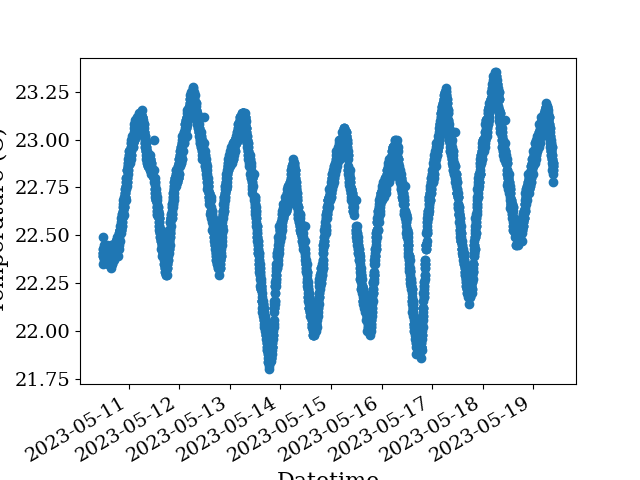

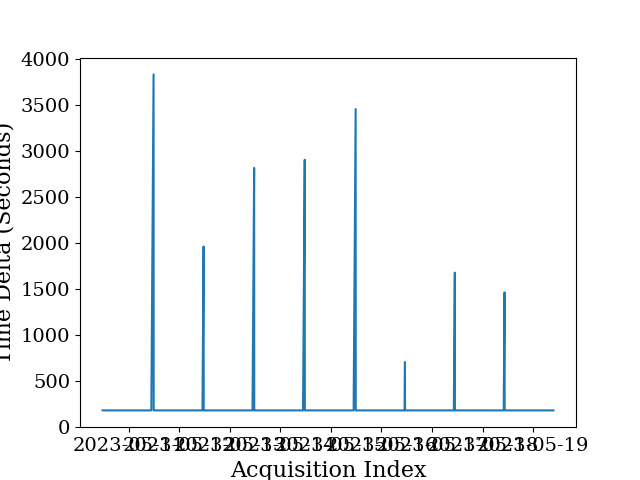

In [35]:
#time delta analysis
datetimes_str = np.loadtxt(f'{dataDir}database.txt',
                        skiprows=1,
                        usecols=1,
                        delimiter=',',
                        dtype=str)
datetimes =[]
for date in datetimes_str:
    data = date[10]
    datetimes.append(datetime.strptime(date, ' %Y-%m-%d %H:%M:%S.%f'))


diff = []
for i in range(len(datetimes)-1):
    diff.append((datetimes[i+1] - datetimes[i]).total_seconds())

print(f"diff mean:              {np.mean(diff)}")
print(f"diff median:            {np.median(diff)}")
print(f"diff STD:               {np.std(diff)}")
print(f"diff percent error:     {np.std(diff)/np.mean(diff) * 100}")
print(f"expected single time:   {2**24/s.SAMPLE_RATE * 250}")
print(f"total time:             {(datetimes[-1] - datetimes[0]).total_seconds()}")
print(f"expected total time:    {2**24/s.SAMPLE_RATE * s.NOF_BUFFERS_TO_RECEIVE * s.NOF_ACQUISITIONS_TO_TAKE}")

plt.close('all')
#TEMPERATURE
plt.figure()
plt.scatter(datetimes, databaseDf['TEMP'] -273.15)
#databaseDf.plot(x='DATETIME', y='TEMP')
plt.gcf().autofmt_xdate()
plt.xlabel('Datetime')
plt.ylabel('Temperature (C)')
plt.show()


plt.figure()
plt.plot(datetimes[1:], diff)
plt.xlabel('Acquisition Index')
plt.ylabel('Time Delta (Seconds)')
plt.show()

In [8]:
#pack pre proc dataset

try:
    f.close()
    print("closed")
except:
    print("didn't close")
    pass

rawDataDir      = dataDir + 'data/'
fileList        = os.listdir(rawDataDir)
fileList.sort(key=lambda f: int(re.sub('\D', '', f)))
newDataDir      = dataDir
fileName        = 'packedh5.hdf5'
if 0: #will overwrite!!!

    f               = h5py.File(newDataDir + fileName, 'w')

    #init empty dataset
    print(f'initilizing dataset 8388609x{totalAcqs}')
    specA_W    = f.create_dataset('spec_W_chA', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    specB_W    = f.create_dataset('spec_W_chB', (8388609, totalAcqs), chunks = (2**16,2**0), dtype = 'f')
    print(specA_W)
    print(specB_W)

    ##############################################################
    #Main loop
    ##############################################################
    numFiles        = 0
    numMeasData     = 0
    numRigolSpec    = 0

    compType = False
    chunks = None #must add chunks arg to create dataset calls

    for fileidx, file in enumerate(fileList):
        if fileidx % 1 == 0:
            print(file)
        dataset         = h5py.File(rawDataDir +  file, 'r')
        numFiles        += 1
        measDataKeys    = list(dataset.keys())
        measDataKeys.sort(key=lambda f: int(re.sub('\D', '', f)))
        #measDataKeys = [int(key) for key in measDataKeys]

        for measData in measDataKeys:
            print(measData)
            measDataInt = int(measData)
            '''Dumb check. Is the date in raw h5 measData the same as what
            the database thinks it is? Since we previously check that dates
            are consectutive this also checks that dates 
            in raw h5 are consecutive'''
            '''datasetDf   = pd.read_hdf(rawDataDir + file, key = measData)#raw H5 
            dateTimeStr = datasetDf.columns[0][0]#datetime extracted from raw H5
            dateTime    = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S.%f')'''

            '''Check database at a measData has the same datetime as we are about
            to load into new h5'''
            '''if not (dateTime==database[database['measData'] == measDataInt].index):
                print('Dates got jumbled at measData', measDataInt)'''
            specA_W_np        = np.float32(dataset[measData]['chASpec_W'])
            specB_W_np        = np.float32(dataset[measData]['chBSpec_W'])


            specA_W[:, measDataInt]    = specA_W_np
            specB_W[:, measDataInt]    = specB_W_np

f.close()

closed
initilizing dataset 8388609x4176
<HDF5 dataset "spec_W_chA": shape (8388609, 4176), type "<f4">
<HDF5 dataset "spec_W_chB": shape (8388609, 4176), type "<f4">
0.hdf5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1.hdf5
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
2.hdf5
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
3.hdf5
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
4.hdf5
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
5.hdf5
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
6.hdf5
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
7.hdf5
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
8.hdf5
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
9.hdf5
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
10.hdf5
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
11.hdf5
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
12.hdf5
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
13.hdf5
208
209
21

term idxs to plot [1, 1841, 1857, 1873, 1905, 2001, 2305]


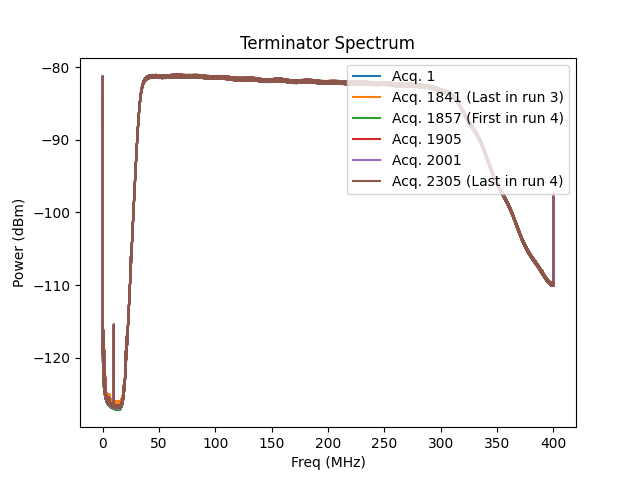

In [3]:
#Looking at 
fileName        = 'packedh5.hdf5'
f               = h5py.File(dataDir + fileName, 'r')
vetoSpec = f['spec_W_chA'][:,1]
antSpec  = f['spec_W_chB'][:, 1+(4*464)]


freqasdf = np.linspace(0,400,2**23)
plt.close('all')
plt.figure()
#plt.plot(freqasdf, 10*np.log10(vetoSpec[1:]*1000))

termToPlt = [1,
             1841,
            1+(4*464),
            1873,
            1905,
            2001,
            2305]
pltLabels = ['Acq. 1',
             'Acq. 1841 (Last in run 3)',
             'Acq. 1857 (First in run 4)',
             'Acq. 1905',
             'Acq. 2001',
             'Acq. 2305 (Last in run 4)']

print('term idxs to plot', termToPlt)

for label, idx in zip (pltLabels, termToPlt):
    plt.plot(freqasdf, 10*np.log10(f['spec_W_chB'][1:, idx]*1000),
             label = label
             )

plt.title('Terminator Spectrum')
plt.legend(loc = 'upper right')
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (dBm)')
f.close()


term idxs to plot [1, 461, 466]


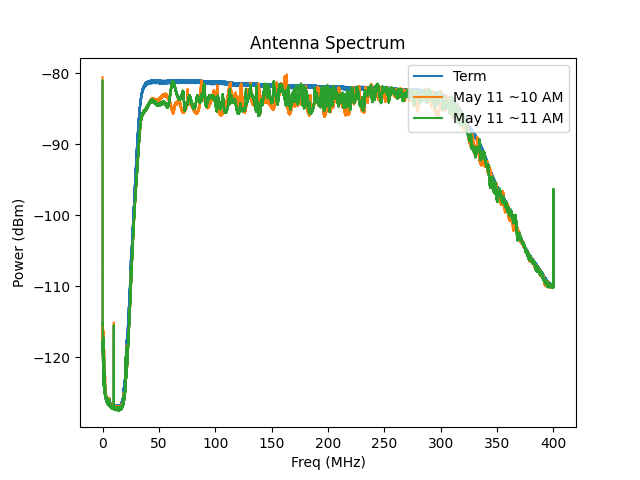

In [4]:
#Looking at stability of thermal wiggles
fileName        = 'packedh5.hdf5'
f               = h5py.File(dataDir + fileName, 'r')
vetoSpec = f['spec_W_chA'][:,1]
antSpec  = f['spec_W_chB'][:, 1+(4*464)]


freqasdf = np.linspace(0,400,2**23)
plt.close('all')
plt.figure()
#plt.plot(freqasdf, 10*np.log10(vetoSpec[1:]*1000))
termToPlt = [1,
             461,
             466]
pltLabels = ['Term',
             'May 11 ~10 AM',
             'May 11 ~11 AM']


print('term idxs to plot', termToPlt)

for label, idx in zip (pltLabels, termToPlt):
    plt.plot(freqasdf, 10*np.log10(f['spec_W_chB'][1:, idx]*1000),
             label = label
             )

plt.title('Antenna Spectrum')
plt.legend(loc = 'upper right')
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (dBm)')
f.close()


term idxs to plot [1, 461, 466]


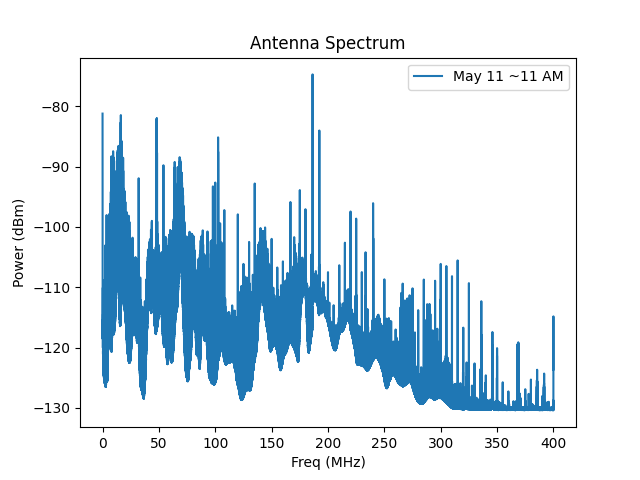

In [10]:
#Looking veto spec
fileName        = 'packedh5.hdf5'
f               = h5py.File(dataDir + fileName, 'r')
vetoSpec = f['spec_W_chA'][:,1]



freqasdf = np.linspace(0,400,2**23)
plt.close('all')
plt.figure()
#plt.plot(freqasdf, 10*np.log10(vetoSpec[1:]*1000))
termToPlt = [1,
             461,
             466]
pltLabels = ['Term',
             'May 11 ~10 AM',
             'May 11 ~11 AM']


print('term idxs to plot', termToPlt)


plt.plot(freqasdf, 10*np.log10(f['spec_W_chA'][1:, 1200]*1000),
        label = label
        )

plt.title('Antenna Spectrum')
plt.legend(loc = 'upper right')
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (dBm)')
f.close()


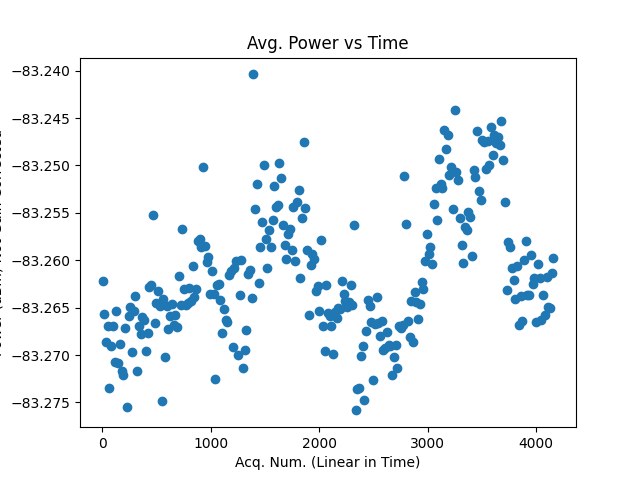

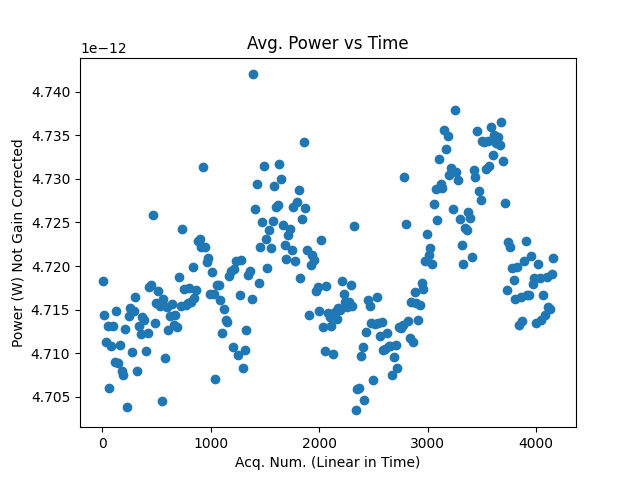

In [11]:
f               = h5py.File(dataDir + fileName, 'r')
avgPow          = []
deadTermIdxs    = np.arange(1,4175,16)
for i in deadTermIdxs:
    avgPow.append(f['spec_W_chB'][100000::10000, i].mean())
f.close()

plt.close('all')
plt.title('Avg. Power vs Time')
plt.scatter(deadTermIdxs,10*np.log10((avgPow) ) + 30)
plt.xlabel('Acq. Num. (Linear in Time)')
plt.ylabel('Power (dBm) Not Gain Corrected')
plt.show()

plt.figure()
plt.title('Avg. Power vs Time')
plt.scatter(deadTermIdxs, avgPow)
plt.xlabel('Acq. Num. (Linear in Time)')
plt.ylabel('Power (W) Not Gain Corrected')
plt.show()

In [ ]:
f               = h5py.File(dataDir + fileName, 'r')
print(f.keys())
print(f['spec_W_chA'][0,:])

f.close()

In [18]:
len(antIdx) * 

3897

In [2]:
#Average and save spectra

#location of packed h5
fileName        = 'packedh5.hdf5'


def avgSpecFromPacked(avgIdxs, specStr):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f[specStr][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec

def rollingMadLim(spec,
    nSigma = 1,
    order = 1,
    fc_numBins = 100
):
    specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)
    window = 1000

    rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)

    filter_fc           = 30 * window
    filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
    diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
    rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
    return rollMadLim, specFiltered, nSigma, order, fc_numBins

#Average, filter and save
if 0:
    f               = h5py.File(dataDir + fileName, 'r')
    
    #antIdxs     = range(0, totalAcqs-1, 2)[0:-1]
    #termIdxs    = range(1, totalAcqs-1, 2)
    avgAntSpec  = avgSpecFromPacked(antIdx, 'spec_W_chB')
    print('Done with ant avg')
    #avgVetoSpec  = avgSpecFromPacked(antIdx, 'spec_W_chA')
    print('Done with veto avg')
    avgTermSpec = avgSpecFromPacked(termIdx, 'spec_W_chB')
    print('Done with term avg')

    np.save('./avgSpecs_gitignore/avgAntSpec_W' + antSpecSufix, avgAntSpec)
    np.save('./avgSpecs_gitignore/avgVetoSpec_W' + vetoSpecSufix, avgVetoSpec)
    np.save('./avgSpecs_gitignore/avgTermSpec_W' + termSpecSufix, avgTermSpec)
    print('Done saving raw spectra')

    #filter/rolling mad limit and save
    #antRollingMadLim, antFilt, Sigma, order, fc_numBins     = rollingMadLim(avgAntSpec)
    #termRollingMadLim, termFilt, nSigma, order, fc_numBins   = rollingMadLim(avgTermSpec)

    #np.save(f'./avgSpecs_gitignore/antRollingMadLim_W_nSigma{nSigma}_order{order}_fc{fc_numBins}' + antSpecSufix, antRollingMadLim)
    #np.save(f'./avgSpecs_gitignore/termRollingMadLim_W_nSigma{nSigma}_order{order}_fc{fc_numBins}'+ termSpecSufix , termRollingMadLim)

    #np.save(f'./avgSpecs_gitignore/antFilt_W_nSigma{nSigma}_order{order}_fc{fc_numBins}' + antSpecSufix, antFilt)
    #np.save(f'./avgSpecs_gitignore/termFilt_W_nSigma{nSigma}_order{order}_fc{fc_numBins}'+ termSpecSufix, termFilt)

    f.close()


Text(0.5, 0, 'Freqency (MHz)')

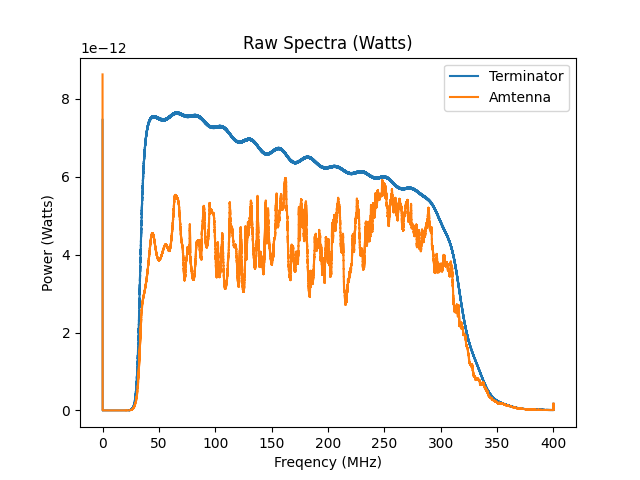

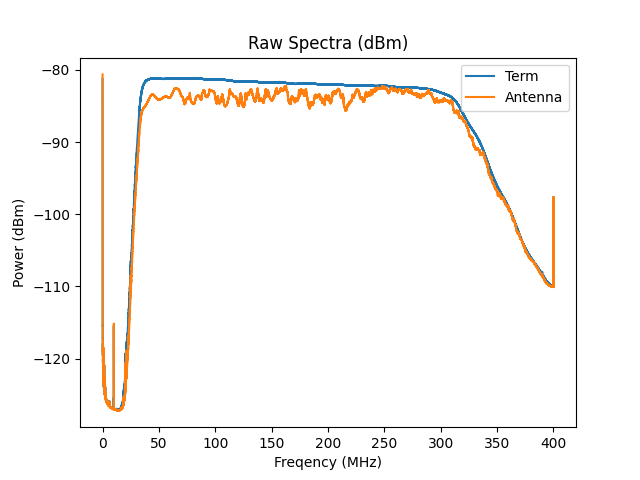

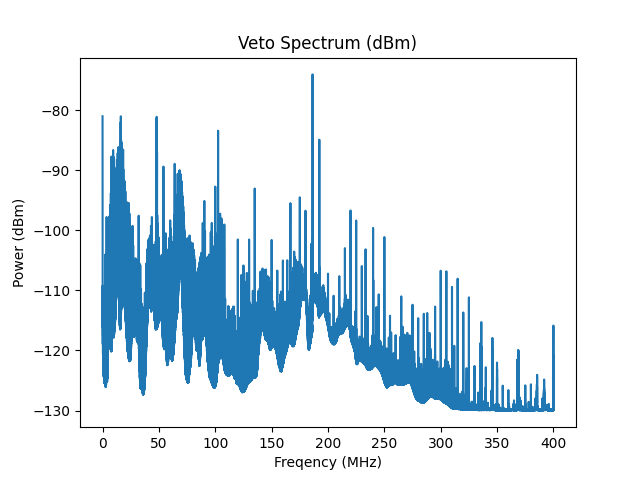

In [2]:
#load files generated in previous cell
# only saved nSigma=1, changing nSigma just multplies the rolling mad limit in this cell
nSigma      = 5
order       = 1
fc_numBins  = 100

avgAntSpec          = np.load('./avgSpecs_gitignore/avgAntSpec_W'+ antSpecSufix + '.npy', allow_pickle=True)
avgTermSpec         = np.load('./avgSpecs_gitignore/avgTermSpec_W' + termSpecSufix + '.npy' , allow_pickle=True)
avgVetoSpec         = np.load('./avgSpecs_gitignore/avgVetoSpec_W' + vetoSpecSufix + '.npy', allow_pickle=True)

'''
filtAntSpec         = np.load(f'./avgSpecs_gitignore/antFilt_W_nSigma1_order{order}_fc{fc_numBins}' + antSpecSufix + '.npy', 
    allow_pickle=True
)
filtTermSpec        = np.load(f'./avgSpecs_gitignore/termFilt_W_nSigma1_order{order}_fc{fc_numBins}' + termSpecSufix + '.npy', 
    allow_pickle=True
)
termRollingMadLim   = nSigma * np.load(f'./avgSpecs_gitignore/termRollingMadLim_W_nSigma1_order{order}_fc{fc_numBins}' + termSpecSufix + '.npy',
    allow_pickle=True
)
antRollingMadLim   = nSigma * np.load(f'./avgSpecs_gitignore/antRollingMadLim_W_nSigma1_order{order}_fc{fc_numBins}' + antSpecSufix +'.npy',
    allow_pickle=True
)'''


#plot raw spectra
freqs       = np.linspace(0, 400e6, 2**23, dtype=np.float64)

plt.close('all')

plt.title('Raw Spectra (Watts)')
plt.plot(freqs/1e6, avgTermSpec[1:], label = 'Terminator')
plt.plot(freqs/1e6, avgAntSpec[1:], label = 'Amtenna')
plt.ylabel('Power (Watts)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')

plt.figure()
plt.title('Raw Spectra (dBm)')
plt.plot(freqs/1e6, 10*np.log10(avgTermSpec[1:]*1000), label = 'Term')
plt.plot(freqs/1e6, 10*np.log10(avgAntSpec[1:]*1000), label = 'Antenna')
plt.ylabel('Power (dBm)')
plt.xlabel('Freqency (MHz)')
plt.legend(loc = 'upper right')

plt.figure()
plt.title('Veto Spectrum (dBm)')
plt.plot(freqs/1e6, 10*np.log10(avgVetoSpec[1:]*1000))
plt.ylabel('Power (dBm)')
plt.xlabel('Freqency (MHz)')



In [ ]:
print(f'nSigma: {nSigma}')

pltFreqStart = 45e6
pltFreqStop = 305e6
pltIdxStart = freq2Idx(pltFreqStart, freqs)
pltIdxStop = freq2Idx(pltFreqStop, freqs)
numBins         = pltIdxStop - pltIdxStart
expectedCans    = (1 - math.erf(nSigma/np.sqrt(2)) ) * numBins /2

antCanList_idx = ((filtAntSpec > antRollingMadLim)) 
antCandidateTotal = (antCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{antCandidateTotal} antenna candidates")
print(f"Expected {round(expectedCans,4)} candidates at {nSigma} sigma")

termCanList_idx = ((filtTermSpec > termRollingMadLim)) 
termCandidateTotal = (termCanList_idx[pltIdxStart:pltIdxStop].sum())
print(f"{termCandidateTotal} term candidates")
print(f"Expected {round(expectedCans,4)} candidates at {nSigma} sigma")


plt.close('all')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(antRollingMadLim)[pltIdxStart:pltIdxStop], label = f'{nSigma} Sigma')
plt.text(200,.75e-14, f'{antCandidateTotal} candidates',size=16)
plt.title(f"Antenna Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')
plt.legend(loc='upper right')

plt.figure()
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6,(termRollingMadLim)[pltIdxStart:pltIdxStop],label = f'{nSigma} Sigma')
plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
plt.title(f"Terminator Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
plt.xlabel('Frequency (MHz)')
plt.ylabel('Filtered Watts')
plt.legend(loc='upper right')

if 0:
    plt.figure()
    plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtAntSpec[pltIdxStart:pltIdxStop], label = 'Antenna')
    plt.plot(freqs[pltIdxStart:pltIdxStop]/1e6, filtTermSpec[pltIdxStart:pltIdxStop], label = 'Terminator', alpha = .5)
    plt.text(200,.75e-14, f'{termCandidateTotal} candidates',size=16)
    plt.title(f"Filtered Linear Power from {pltFreqStart/1e6} to {pltFreqStop/1e6}Mhz")
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Filtered Watts')
    plt.legend(loc = 'upper right')

In [ ]:
#show nice normal distribution for antenna data normilized to rolling MAD


def gaus(x, a, mu, sigma):
    return a * np.exp(-((x-mu)**2)/2*sigma)



normAntSpec     = (filtAntSpec/antRollingMadLim*nSigma)[pltIdxStart:pltIdxStop]
#bins            = 100
bins            = np.histogram_bin_edges(normAntSpec, 'fd')

histY, histX    = np.histogram(normAntSpec, bins = bins)

# Compute bin centers
bin_centers = histX[:-1] + np.diff(histX) / 2


popt, pcov      = curve_fit(gaus, bin_centers, histY, p0=[10**4, 0, 1])

print(f"fit mean: {popt[1]}")
print(f"fit sigma: {popt[2]}")

plt.close('all')
plt.title("Filtered Antenna Data, Normilized to Rolling MAD")
plt.hist(normAntSpec, bins=bins, log=True)
plt.plot(histX, gaus(histX, popt[0], popt[1], popt[2]), label = f'Gaussian Fit {len(bins)} bins. mu={round(popt[1],5)}, sigma={round(popt[2], 5)}')
plt.xlabel('Sigma')
plt.ylabel('Counts')
plt.show()
plt.legend()

In [15]:
#generate lists of candidates

antCanIdx   = (np.where(antCanList_idx  == True))[0]
termCanIdx  = (np.where(termCanList_idx == True))[0]

antMask     = (antCanIdx >= pltIdxStart) & (antCanIdx <= pltIdxStop)
termMask    = (termCanIdx >= pltIdxStart) & (termCanIdx <= pltIdxStop)

antCanIdx   = antCanIdx[antMask]
termCanIdx  = termCanIdx[termMask]

antCanFreqs =np.asarray([idx2freq(idx,freqs) for idx in antCanIdx])
termCanFreqs=np.asarray([idx2freq(idx,freqs) for idx in termCanIdx])



print(len(antCanFreqs), 'antenna candidates')
#print('at freqs. ', antCanFreqs/1e6)
print(len(termCanFreqs), 'terminator candidates')
print('at freqs. ', termCanFreqs/1e6)

NameError: name 'antCanList_idx' is not defined

In [ ]:
def consolidateCandidates(rawCanList, freqs, stepsize=1):
    '''
    Takes array of indices of candidates and returns a data frame
    with one row per candidate and columns with the candidate frequency,
    number of bins wide and the starting index of that candidate
    Inputs:
        rawCanList (1D list or np array): list of indices of candidates
        reqs (1D list or np array): list of frequencies
        stepsize: should be 1 to find adjecent candidates
    Calls:
        idx2Freq()
    '''
    rawCanList = np.asarray(rawCanList)
    splitList =  np.split(rawCanList, np.where(np.diff(rawCanList) > stepsize)[0]+1)
    canList = [can[0] for can in splitList]
    canListFreq =  [idx2freq(can[0],freqs) for can in splitList]
    canLenList = [len(can) for can in splitList]
    candidate_df = pd.DataFrame()
    candidate_df['canFreq_Mhz'] = [freq/1e6 for freq in canListFreq]
    candidate_df['numBins'] = canLenList
    candidate_df['idx'] = canList
    #candidate_df['idx absolute'] = [idx + idxStart for idx in canList]
    diffArr = np.zeros(len(canList))
    diffArr[0] =  float('nan')
    diffArr[1:] = np.diff(canList)
    candidate_df['deltaIdx'] = diffArr
    candidate_df['deltaFreq_Hz'] = [deltaIdx* (s.SAMPLE_RATE) /s.CH0_RECORD_LEN for deltaIdx in diffArr]

    return candidate_df

stepsize = 10
candidate_df = consolidateCandidates(antCanIdx, freqs, stepsize=stepsize)
#candidate_df.to_csv(f'./candidateListCsvs/candidateList_run1_firstThird_diffGreaterThan10Bins_{nSigma}sigma_fc100bins_Order1_4_24_23.csv')
candidate_df

In [ ]:

fig, ax = plt.subplots()

ax.plot(np.arange(0, len(freqs), 1), np.zeros(len(freqs)), alpha = 0)
ax.set_xlabel('bin number')
ax.xaxis.tick_top()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_ticks_position('top')
ax.set_xlim(pltIdxStart, pltIdxStop)
ax.set_ylim(np.min(filtAntSpec[pltIdxStart:pltIdxStop]), 
    np.max(filtAntSpec[pltIdxStart:pltIdxStop]*1.05)
)
ax.set_ylabel('Linear Power')

ax2 = ax.twiny()

ax2.plot(freqs/1e6, filtAntSpec[1:])
ax2.plot(freqs/1e6,  antRollingMadLim[1:], label = f'{nSigma} sigma (rolling mad)')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Linear Power (W)')


#ax2.plot(np.arange(pltIdxStart, pltIdxStop, 1), antRollingMadLim[pltIdxStart:pltIdxStop], 'orange', label = '5 sigma (rolling mad)')
ax2.scatter(freqs[candidate_df['idx']]/1e6, antRollingMadLim[candidate_df['idx']], color ='r', marker = 'x')
ax2.set_xlim(pltFreqStart/1e6, pltFreqStop/1e6)
#ax2.set_ylim(np.min(filtAntSpec[pltIdxStart:pltIdxStop]), 
#    np.max(filtAntSpec[pltIdxStart:pltIdxStop])
#)

ax2.legend(loc = 'upper right')
ax2.xaxis.tick_top()

plt.show()

print('stepsize = %i ' %stepsize)
print('butter filter (order = %i and' %order, 'f_c = %i'  %fc_numBins, 'bins)')

print('number of candidates = ', len(candidate_df['idx']) )

In [37]:
#create a list of bunches of spurs
print()
idxDiff = np.diff(antCanIdx)
#print(idxDiff)
diffMask = np.where(idxDiff == 1, True, False)
diffMask = np.append(False, diffMask,)

onesIdxs = antCanIdx[diffMask]
#print(freqs[onesIdxs])

hist, binEdges = np.histogram(idxDiff, bins = 10000, range=(1,10001))
#print(binEdges)
histNoZeros = []
binsNoZeros = []
for i, val in enumerate(hist):
    if val != 0 and val != 1:
        histNoZeros.append(val)
        binsNoZeros.append(binEdges[i])
binsNoZeros =[str(int(bin)) for bin in binsNoZeros]

count = 0
for val in idxDiff:
    if int(val) > 10000:
        count += 1
print("Count of differences greater than 10000: ", count)


plt.close('all')
plt.figure()
#plt.semilogy()
plt.scatter(np.arange(0, len(idxDiff), 1),(idxDiff))
plt.title('Difference Between Adjacent Candidates')
plt.xlabel('Index Within Candidate List')
plt.ylabel('Difference')
plt.grid()
plt.tight_layout()

#hist without skipping empty bins. Not useful
if 0:
    plt.figure();
    plt.hist(idxDiff, bins = 10000, range=(2,10002));
    plt.title('Difference Between Adjacent Candidates')
    plt.xlabel('Difference')
    plt.ylabel('Counts')

#hist skipping unused bins
plt.figure();
plt.bar(binsNoZeros, histNoZeros);
plt.title('Difference Between Adjacent Candidates');
plt.xlabel('Difference');
plt.ylabel('Counts');
plt.xticks(rotation='vertical');
plt.tight_layout()
plt.grid()

NameError: name 'antCanIdx' is not defined

In [38]:
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler, FigureWidgetResampler

x = freqs[pltIdxStart:pltIdxStop]
main_data = filtAntSpec[pltIdxStart:pltIdxStop]
sigmaLine = antRollingMadLim[pltIdxStart:pltIdxStop]
veto_data = avgVetoSpec[pltIdxStart:pltIdxStop]

# Create the subplots with shared x-axis
fig = FigureWidgetResampler(make_subplots(rows=2, cols=1, shared_xaxes=True),  default_n_shown_samples=10000)

# Add the main data trace to the first subplot
fig.add_trace(
    go.Scattergl(
        x=x,
        y=main_data,
        mode='lines',
        marker=dict(
            color='blue',
            size=1
        ),
        name='Main Channel, filtered Watts'
    ),
    row=1, col=1
)

# Add the sigma limit trace to the first subplot
fig.add_trace(
    go.Scattergl(
        x=x,
        y=sigmaLine,
        mode='lines',
        marker=dict(
            color='orange',
            size=1
        ),
        name=f'{nSigma} sigma limit'
    ),
    row=1, col=1
)
 #add an x where main channel power goes over n sigma
fig.add_trace(go.Scatter(
    x=freqs[candidate_df['idx']],
    y=antRollingMadLim[candidate_df['idx']],
    mode='markers',
    marker=dict(color='red', symbol='x'),
    name = f'Main power > {nSigma} sigma'
))
 

# Add the veto data trace to the second subplot
fig.add_trace(
    go.Scattergl(
        x=x,
        y=10 * np.log10(veto_data * 1000),
        #y = veto_data,
        mode='lines',
        marker=dict(
            color='red',
            size=1
        ),
        name='Veto Channel'
    ),
    row=2, col=1
)

# Set the subplot titles and axis labels
fig.update_layout(
    title='Main and Veto Channels',
    xaxis_title='Frequency (MHz)',
    yaxis_title='Filtered Main Channel (Watts)',
    yaxis2_title='Veto (dBm)',
    yaxis=dict(exponentformat='power')
)

# Wrap the figure with FigureWidgetRescaler for resampling
#resampler = FigureWidgetRescaler(fig)

# Display the resampled figure
#resampler.widget()


NameError: name 'pltIdxStart' is not defined

In [48]:
#get plot for thermal noise section of thesis. Compare antenna position to equlivant amout of terminator data. 
# Since term is constant, you can take it from several days.

#final acqNum for pos1 is 463. There are less term scans than this. Just take 0:number of term scans
print(len(antIdx[0:len(termIdx)]))
print(len(termIdx))


#Average, filter and save
if 1:
    f               = h5py.File(dataDir + fileName, 'r')
    avgAntSpec = avgSpecFromPacked(antIdx[0:len(termIdx)], 'spec_W_chB')
    print('done with ant spec')
    avgAntSpecPos2 = avgSpecFromPacked(antIdx[463:500], 'spec_W_chB')
    print('done with ant spec')
    avgTermSpec = avgSpecFromPacked(termIdx, 'spec_W_chB')
    f.close()




261
261
done with ant spec
done with ant spec


'\nplt.figure()\nfreqs = np.linspace(0,400,2**23)\nplt.plot(freqs, 10*np.log10(avgAntSpec[1:]*1000))\nplt.plot(freqs, 10*np.log10(avgTermSpec[1:]*1000))\n\n#plt.plot(freqs, avgAntSpec[1:])\n#plt.plot(freqs, avgTermSpec[1:])\n'

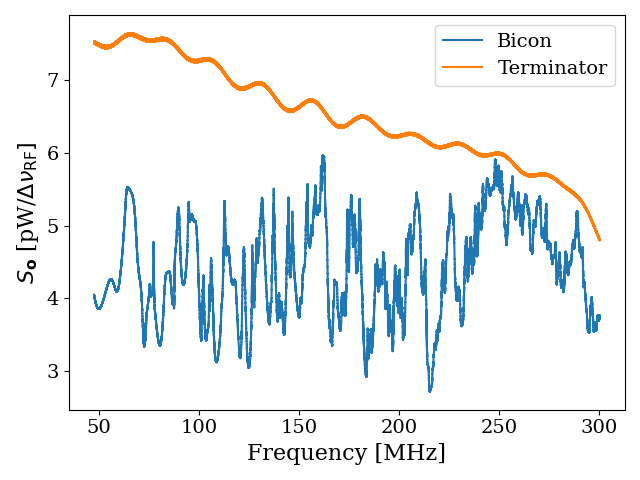

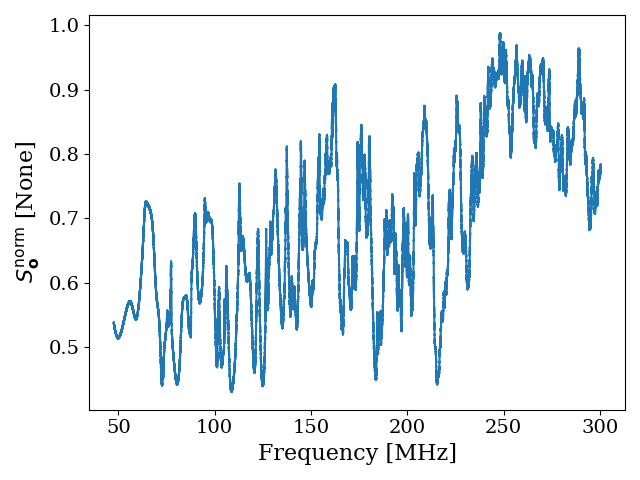

In [3]:
# Plotting format for thesis
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

plt.close('all')
plt.figure()
freqs = np.linspace(0,400,2**23)
plt.plot(freqs[1000000:6300000], 1e12*(avgAntSpec[1:])[1000000:6300000], label = "Bicon")
#plt.plot(freqs[1000000:6300000], 1e12*(avgAntSpecPos2[1:])[1000000:6300000])
plt.plot(freqs[1000000:6300000], 1e12*(avgTermSpec[1:])[1000000:6300000], label = 'Terminator')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$S_\mathbf{o}$ [pW/$\Delta \nu_\mathrm{RF}]$')
plt.tight_layout()
plt.legend()
plt.tight_layout()

plt.figure()
freqs = np.linspace(0,400,2**23)
plt.plot(freqs[1000000:6300000], (avgAntSpec[1:])[1000000:6300000]/((avgTermSpec[1:])[1000000:6300000]), label = "Bicon")
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$S_\mathbf{o}^\mathrm{norm}$ [None]')
plt.tight_layout()

'''
plt.figure()
freqs = np.linspace(0,400,2**23)
plt.plot(freqs, 10*np.log10(avgAntSpec[1:]*1000))
plt.plot(freqs, 10*np.log10(avgTermSpec[1:]*1000))

#plt.plot(freqs, avgAntSpec[1:])
#plt.plot(freqs, avgTermSpec[1:])
'''




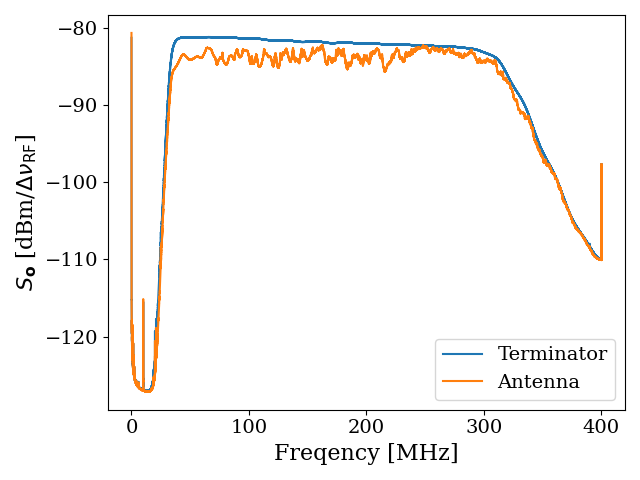

In [34]:
startIdx = int(0)
stopIdx = len(avgAntSpec) - 0
plt.close('all')
plt.figure()
plt.plot(freqs[startIdx:stopIdx], 10*np.log10(avgTermSpec[1:]*1000)[startIdx:stopIdx], label = 'Terminator')
plt.plot(freqs[startIdx:stopIdx], 10*np.log10(avgAntSpec[1:]*1000)[startIdx:stopIdx], label = 'Antenna')
plt.ylabel(r'$S_\mathbf{o}$ [dBm/$\Delta \nu_\mathrm{RF}$]')
plt.xlabel('Freqency [MHz]')
plt.legend(loc = 'lower right')
plt.tight_layout()